# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
#PATH_TO_DATA = "../../data/"
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.word2id = {}
        self.load_wordvec(fname, nmax)
        #self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            j = 0
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                if word not in [',','.','#','?','!',',','"',"'",':',';','(',')', '/']: # Remove punctuation
                    self.word2vec[word] = np.fromstring(vec, sep=' ') 
                    self.word2id[word] = j
                    j += 1
                # Code to not differentiate word and word.lower()
                #self.word2vec[word.lower()] = np.fromstring(vec, sep=' ') if not (word.lower() in self.word2vec.keys()) else (np.fromstring(vec, sep=' ')+self.word2vec[word.lower()])/2
                #self.word2id[word.lower()] = i if not (word.lower() in self.word2id.keys()) else self.word2id[word.lower()]
                if j == (nmax):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))


    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        if w in self.word2vec.keys():
            # Create a list with the score of each word
            most_similar_list = [self.score(word,w) for word in self.word2vec.keys()]
            # return the 5 most similar words
            most_similar_list_argsort = np.argsort(most_similar_list)
            return [self.id2word[most_similar_list_argsort[-k-2]] for k in range(K)]
        else:
            return w+' is missing of vocabulary'
       
    
    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        try:
            return np.dot(self.word2vec[w1], self.word2vec[w2])/((np.linalg.norm(self.word2vec[w1]))*(np.linalg.norm(self.word2vec[w2])))
        except KeyError as e:
            return e

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [5]:
import warnings
import time

class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        sentemb = []
        for sent in sentences:
            if idf is False:
                # compute the mean of word2vec values for each words in a sent
                #sentemb.append(np.mean([self.w2v.word2vec[word] for word in sent.split(' ') if word in self.w2v.word2vec.keys()], axis=0))
                vectors = np.array([self.w2v.word2vec[word] for word in sent.split(' ') if word in self.w2v.word2vec.keys()])
                if vectors.any():
                    sentemb.append(np.mean(vectors, axis=0))
                else:
                    sentemb.append(np.zeros(300))
                
            else:
                # idf-weighted mean of word vectors
                
                # Create a vector with words of each sentences, and their weights from the idf dict
                vectors = [self.w2v.word2vec[word] for word in sent.split(' ') if word in self.w2v.word2vec.keys()]
                weights = [idf[word] for word in sent.split(' ') if word in self.w2v.word2vec.keys()]

                if np.sum(weights)>0:
                    sentemb.append(np.average(vectors, axis=0, weights=weights))
                else:
                    sentemb.append(np.zeros(300))
                
        return sentemb

    def most_similar(self, s, sentences, idf=False, K=5, verbose=False):
        # get most similar sentences and **print** them
        # calculate the average vector for all words in every sentence/document 
        # and use cosine similarity between vectors
        #keys = self.encode(sentences, idf)
        #query = self.encode([s], idf)
        
        # Create many batches to limit memory usage
        size_total = len(sentences)
        batch_size = 3000
        batch_step = int(size_total/batch_size)
        batch_last = size_total - batch_size * batch_step
        
        most_similar_list = [] # Create a list of tuple (sentence, score)
        
        # Some verbose
        time1=time.time()
        timer1 = True
        timer2 = True
        timer3 = True
        # Loop on batches       
        for batch in range(batch_step):
            # Add some timers
            if verbose==True:
                if (batch/batch_step > 1/4)&(timer1):
                    time2=time.time()
                    print('25% done in ', int(time2-time1), ' sec!')
                    timer1=False
                elif (batch/batch_step > 1/2)&(timer2):
                    time3=time.time()
                    print('50% done in ', int(time3-time2), ' sec!')
                    timer2=False
                elif (batch/batch_step > 3/4)&(timer3):
                    time4=time.time()
                    print('75% done in ', int(time4-time3), ' sec!')
                    timer3=False
            
            # Create a list with scores of all words in the batch
            most_similar_list_per_batch = []
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning) # Ignore a RuntimeWarning
                for sent in sentences[batch*batch_size:(batch+1)*batch_size]:
                    _score = self.score(sent, s, idf) # Compute the score between 2 sentences with self.score
                    most_similar_list_per_batch.append(_score if np.any(_score>0) else 0) # Append the score to the list or append 0
                
                
            most_similar_list_per_batch_argsort = np.argsort(most_similar_list_per_batch) # Create argsort list
            
            # Add the 6 similar sentences of this batch to a general list (6 to avoid an if condition to remove the actual sentence)
            for k in range(K+1):
                most_similar_list.append((sentences[batch*batch_size+most_similar_list_per_batch_argsort[-k-1]], most_similar_list_per_batch[most_similar_list_per_batch_argsort[-k-1]]))
            
        # Last batch (same as before)
        if len(sentences[batch_size * batch_step:])>6: # If the last batch is longer than 6
            most_similar_list_per_batch = []
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for sent in sentences[batch_size * batch_step:]:
                    _score = self.score(sent, s, idf)
                    most_similar_list_per_batch.append(_score if np.any(_score>0) else 0)

            most_similar_list_per_batch_argsort = np.argsort(most_similar_list_per_batch)
        
            for k in range(K+1):
                most_similar_list.append((sentences[batch_size*batch_step+most_similar_list_per_batch_argsort[-k-1]], most_similar_list_per_batch[most_similar_list_per_batch_argsort[-k-1]]))
        else: # Add all the last batch if his length is smaller than 6
            for sent in sentences[batch_size * batch_step:]:
                most_similar_list.append((sent, self.score(sent, s, idf) if np.any(self.score(sent, s, idf))>0 else 0))
                
                
                
        # Sort the most_similar_list (sentence, word) to keep the 5 highest scores
        most_similar_list.sort(key=lambda tup: tup[1])
        
        # Some verbose
        time4=time.time()
        if verbose==True:
            print("100% done in ", int(time4-time3), ' sec.')
            print('Total time : ', int(time4-time1), ' sec.')
            print('-'*30)
            print('The 5 most similar sentences are :')
        
        # Get and Print the K similar sentences
        K_similar_sentences = []
        for k in range(K):
            K_similar_sentences.append(most_similar_list[-k-2][0])
            print(most_similar_list[-k-2][0])
        
        return K_similar_sentences
    

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        if s1 and s2:
            return np.dot(self.encode([s1, s2], idf)[0], self.encode([s1, s2], idf)[1]) / (
                (np.linalg.norm(self.encode([s1, s2], idf)[0] * np.linalg.norm(self.encode([s1, s2], idf)[1]))))
        else:
            return 0

        
        
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # Let’s compute the Idf for every word in the vocabulary
        word_idf = np.zeros(len(self.w2v.word2id))
        sentences_only_with_voc = [[word for word in sent.split(' ') if word in self.w2v.word2id.keys()] for sent in sentences]
        sentences_count = len(sentences)
        
        for sent in sentences_only_with_voc:
            indexes = [self.w2v.word2id[word] for word in sent]
            word_idf[indexes] += 1.0
            
        word_idf = np.log(sentences_count / (1 + word_idf).astype(float))     
        return dict(zip(list(self.w2v.word2id.keys()), word_idf)) 


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
def from_txt_to_sent(path):
    with open(path) as f:
        sentences = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    return [x.strip() for x in sentences]
sentences = from_txt_to_sent(os.path.join(PATH_TO_DATA, 'sentences.txt'))
print('Loaded ', len(sentences), ' sentences from sentences.txt')
print('-'*45)

# Build idf scores for each word
idf = {} if True else s2v.build_idf(sentences)
print('-'*45)

# You will be evaluated on the output of the following:
i = 10
print('5 most similar BoV-mean sentences to : "', sentences[i], '"')
#print('!! Should increase pretrained word vectors to have a better result !!')
print('-'*20)
s2v.most_similar('' if not sentences else sentences[i], sentences, verbose=False)# BoV-mean

print('-'*45)
i = 7
j = 13
print('score BoV-mean between : "', '' if not sentences else sentences[i], '" and "', '' if not sentences else sentences[j], '"')
#print('!! Should increase pretrained word vectors to have a better result !!')
print('-'*20)
score = s2v.score('' if not sentences else sentences[i], '' if not sentences else sentences[j])
print(score)

print('-'*45)
print('-'*45)
# Build the idf dictionary
idf = s2v.build_idf(sentences)
print('IDF dictionary built !')
i = 10
print('5 most similar BoV-idf sentences to : "', sentences[i], '"')
#print('!! Should increase pretrained word vectors to have a better result !!')
print('-'*20)
s2v.most_similar('' if not sentences else sentences[i], sentences, idf=idf, verbose=False)  # BoV-idf

print('-'*45)
i = 7
j = 13
print('score BoV-idf between : "', '' if not sentences else sentences[i], '" and "', '' if not sentences else sentences[j], '"')
print('-'*20)
score = s2v.score('' if not sentences else sentences[i], '' if not sentences else sentences[j], idf)
print(score)

Loaded 100000 pretrained word vectors
Loaded  150736  sentences from sentences.txt
---------------------------------------------
---------------------------------------------
5 most similar BoV-mean sentences to : " 1 smiling african american boy . "
--------------------
an african american man smiling .
a little african american boy and girl looking up .
african american woman bouncing black basketball
an afican american woman standing behind two small african american children .
a girl in black hat holding an african american baby .
---------------------------------------------
score BoV-mean between : " 1 man singing and 1 man playing a saxophone in a concert . " and " 10 people venture out to go crosscountry skiing . "
--------------------
0.5204760325902832
---------------------------------------------
---------------------------------------------
IDF dictionary built !
5 most similar BoV-idf sentences to : " 1 smiling african american boy . "
--------------------
an african ameri

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
def load_wordvec(fname, nmax):
        word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            deleted_words = 0 # Add a counter to keep 50k words with deleted words
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                if word not in [',','.','#','?','!',',','"',"'",':',';','(',')','/','</s>','-']: # Remove some punctuations
                    word2vec[word] = np.fromstring(vec, sep=' ')
                else:
                    deleted_words += 1
                if i == (nmax+deleted_words-1):
                    break
        print('Loaded %s pretrained word vectors' % (len(word2vec)))
        return word2vec
        
en = load_wordvec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax = 50000)
fr = load_wordvec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax = 50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE


common_words = [word for word in en.keys() if word in fr.keys()]
X = np.array([fr[word] for word in common_words]).transpose()
Y = np.array([en[word] for word in common_words]).transpose()

print(len(common_words),'common words.')

18964 common words.


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
from scipy import linalg

U, S, V = linalg.svd(np.dot(Y, X.transpose()))
W_fr2en = np.dot(U, V)
W_en2fr = W_fr2en.transpose()

U.shape, S.shape, V.shape, X.shape, Y.shape, W_fr2en.shape

((300, 300), (300,), (300, 300), (300, 18964), (300, 18964), (300, 300))

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
def score(word_vec, word, lang=en):
    return np.dot(word_vec, lang[word])/(np.linalg.norm(word_vec)*np.linalg.norm(lang[word]))

def most_similar(word, lang=en, K=3):
    most_similar_list = [score(word, w, lang) for w in lang.keys()]
    most_similar_list_argsort = np.argsort(most_similar_list)
    #l = list(lang.keys())[most_similar_list_argsort[-K-1:-1]]
    return [list(lang.keys())[most_similar_list_argsort[-k-2]] for k in range(K)]

def from_en_2_fr(word, K=3):
    if word in en.keys():
        word_vec_fr = np.dot(W_en2fr, en[word])
        l = most_similar(word_vec_fr, fr, K)
        answer = ''
        for w in l[:-1]:
            answer += w+', '
        answer += l[-1]
        return answer
    else:
        return 'Word is not in English vocabulary !'

def from_fr_2_en(word, K=3):
    if word in fr.keys():
        word_vec_en = np.dot(W_fr2en, fr[word])
        l = most_similar(word_vec_en, en, K)
        answer = ''
        for w in l[:-1]:
            answer += w+', '
        answer += l[-1]
        return answer
    else:
        return 'Word is not in French vocabulary !'


print('From french to english : ')
print('\n')
list_fr_2_en = ['fleur', 'arbre', 'café', 'effectivement', 'ordinateur', 'vélo', 'ville']
for w in list_fr_2_en:
    print(w, ' => ', from_fr_2_en(w, 5))
    
print('\n')
print('From english to french :')
print('\n')
list_en_2_fr = ['flower', 'arm', 'bottle', 'car', 'hat', 'health', 'state']
for w in list_en_2_fr:
    print(w, ' =>', from_en_2_fr(w, 5))


From french to english : 


fleur  =>  flowers, rosette, flowered, petals, fleur
arbre  =>  trees, understory, seedlings, shrubs, bushes
café  =>  coffee, cafe, cafés, chocolates, beans
effectivement  =>  obviously, anyway, definitely, anyways, imho
ordinateur  =>  computer, mainframe, workstation, programmable, workstations
vélo  =>  bicycle, bicycles, bicycling, bikes, biking
ville  =>  town, cities, suburb, towns, environs


From english to french :


flower  => fleurs, flowers, fleur, pétales, leaves
arm  => bras, jambe, body, hanche, épaule
bottle  => bouteilles, flacon, bottle, vodka, liqueur
car  => voitures, automobile, porsche, automobiles, roadster
hat  => chapeau, cowboy, shirt, trick, casquette
health  => santé, nutrition, medical, hygiène, épidémiologie
state  => état, etat, federal, government, états


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_train_dev(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:

        score=[]
        sentences=[]
        for sent in f:
            score.append(int(sent.split(' ', 1)[0]))
            sentences.append(sent.split(' ', 1)[1])
        #score = [sent.split(' ', 1)[0] for sent in f]
        #sentences = [sent.split(' ', 1)[1] for sent in f]

    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences], np.array(score)

def load_test(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:
        
        sentences = [sent for sent in f]
        
    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences]
    
train_x, train_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), 'train')
dev_x, dev_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), 'dev')
test_x = load_test(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), 'test')

Loaded 8544 pretrained sentences from train set
Loaded 1101 pretrained sentences from dev set
Loaded 2210 pretrained sentences from test set


In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=190000)
s2v = BoV(w2v)

train_xv = np.array(s2v.encode(train_x))
dev_xv = np.array(s2v.encode(dev_x))
test_xv = np.array(s2v.encode(test_x))
print('Average of word vectors done !')

idf = s2v.build_idf(train_x+dev_x)
print('IDF dictionary built !')

train_xi = np.array(s2v.encode(train_x, idf))
dev_xi = np.array(s2v.encode(dev_x, idf))
test_xi = np.array(s2v.encode(test_x, idf))
print('Weighted average of word vectors done !')

Loaded 190000 pretrained word vectors
Average of word vectors done !
IDF dictionary built !
Weighted average of word vectors done !


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to create a logistic regression model. Return the fitted model
def logReg(data, model_LR=LogisticRegression()):
    train_x = data[0]
    train_y = data[1]
    dev_x = data[2]
    dev_y = data[3]
    model_LR.fit(train_x, train_y) # Fit the model
    pred = model_LR.predict(dev_x) # Predict dev
    print(model)
    print('Train error : ', model_LR.score(train_x, train_y)) # Print score
    print('Dev error : ', accuracy_score(pred, dev_y))
    print('Confusion matrix :')
    print(confusion_matrix(pred, dev_y))
    print('\n')
    return model_LR

''' After a grid_search on weighted/average, C & penalty, 
 the best score on train/dev is reach with idf_average, l2 and C=0.14 '''

# Selection of weighted dataset
average_bov = [train_xv, train_y, dev_xv, dev_y]
weighted_bov = [train_xi, train_y, dev_xi, dev_y]

# Create and fit the model with optimized parameters, and print some metrics
print(confusion_matrix(dev_y, dev_y))
print('\n')

print('Average of word vectors : ')
model = LogisticRegression(penalty='l2', C=0.16)
model = logReg(average_bov, model)

print('Weighted average of word vectors : ')
model = LogisticRegression(penalty='l2', C=0.14)
model = logReg(weighted_bov, model)

[[139   0   0   0   0]
 [  0 289   0   0   0]
 [  0   0 229   0   0]
 [  0   0   0 279   0]
 [  0   0   0   0 165]]


Average of word vectors : 
LogisticRegression(C=0.16, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train error :  0.4643024344569288
Dev error :  0.4268846503178928
Confusion matrix :
[[ 11   6   4   2   0]
 [105 198  96  49  12]
 [  2   8  10   3   1]
 [ 18  77 113 210 111]
 [  3   0   6  15  41]]


Weighted average of word vectors : 
LogisticRegression(C=0.14, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train error :  0.4734316479400749
Dev error :  0.4305177111716621
Confusion matrix :

In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
# Prediction
test_y = model.predict(test_xi)

# Saving results
file = open('data/logreg_bov_y_test_sst.txt', 'w')
for l in test_y:
    file.write(str(l))
    file.write("\n")
file.close()
print('Results saved !')

Results saved !


In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
# Different test with MultinomialNB, LinearSVC and RandomForest shows that LinearSVC has better results
from sklearn.svm import LinearSVC


def fitting_other_models(data, model):
    train_x = data[0]
    train_y = data[1]
    dev_x = data[2]
    dev_y = data[3]
    model.fit(train_x, train_y) # Fit the model
    pred = model.predict(dev_x) # Predict dev
    print(model)
    print('Score on train : ', model.score(train_x, train_y)) # Print score
    print('Score on dev : ', accuracy_score(pred, dev_y))
    print(confusion_matrix(pred, dev_y))
    print('\n')
    return model

weighted_bov = [train_xi, train_y, dev_xi, dev_y]

# Create and fit the model with optimized parameters, and print some metrics
model = LinearSVC()
model = fitting_other_models(weighted_bov, model)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Score on train :  0.4868913857677903
Score on dev :  0.40599455040871935
[[ 25  19  16   5   2]
 [ 88 170  75  42   9]
 [  8  27  21  20   2]
 [ 11  62  99 166  87]
 [  7  11  18  46  65]]




# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras
import matplotlib.pyplot as plt

C:\Users\Romain\Anaconda3V2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
#PATH_TO_DATA = "../../data/"
PATH_TO_DATA = 'data/'

# TYPE CODE HERE
def load_train_dev(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:

        score=[]
        sentences=[]
        for sent in f:
            score.append(int(sent.split(' ', 1)[0]))
            sentences.append(sent.split(' ', 1)[1])

    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences], np.array(score)

def load_test(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:
        
        sentences = [sent for sent in f]
        
    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences]

def get_dummies(data): # transform np.array into dummy variable to fit models
    result = np.array([[0 for i in range(data.min(), data.max()+1)] for i in data])
    for i, k in enumerate(data):
        result[i][k] = 1
    return result
    
train_x, train_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), 'train')
dev_x, dev_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), 'dev')
test_x = load_test(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), 'test')

train_y = get_dummies(train_y)
dev_y = get_dummies(dev_y)

Loaded 8544 pretrained sentences from train set
Loaded 1101 pretrained sentences from dev set
Loaded 2210 pretrained sentences from test set


In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text

filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
train_voc_size = round(len([word for sent in train_x for word in sent.split(' ')])*1.5)

train_int = [text.one_hot(text=sent, n=train_voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") 
             for sent in train_x]
dev_int = [text.one_hot(text=sent, n=train_voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") 
           for sent in dev_x]
test_int = [text.one_hot(text=sent, n=train_voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") 
            for sent in test_x]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing import sequence

max_len = len(max(train_int, key=len))

train_int = sequence.pad_sequences(train_int, maxlen=max_len)
dev_int = sequence.pad_sequences(dev_int, maxlen=max_len)
test_int = sequence.pad_sequences(test_int, maxlen=max_len)

print(max_len)

49


## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = train_voc_size  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' #'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         73603200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 73,696,965
Trainable params: 73,696,965
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [==============================] - 203s 24ms/step - loss: 1.5550 - acc: 0.2983 - val_loss: 1.4749 - val_acc: 0.3606
Epoch 2/8
8544/8544 [==============================] - 186s 22ms/step - loss: 1.3502 - acc: 0.4068 - val_loss: 1.3653 - val_acc: 0.3833
Epoch 3/8
8544/8544 [==============================] - 187s 22ms/step - loss: 1.1381 - acc: 0.4692 - val_loss: 1.3832 - val_acc: 0.3797
Epoch 4/8
8544/8544 [==============================] - 200s 23ms/step - loss: 0.9818 - acc: 0.5405 - val_loss: 1.4529 - val_acc: 0.3915
Epoch 5/8
8544/8544 [==============================] - 202s 24ms/step - loss: 0.8328 - acc: 0.6520 - val_loss: 1.5619 - val_acc: 0.3924
Epoch 6/8
8544/8544 [==============================] - 214s 25ms/step - loss: 0.7013 - acc: 0.7440 - val_loss: 1.7623 - val_acc: 0.4042
Epoch 7/8
8544/8544 [==============================] - 191s 22ms/step - loss: 0.5708 - acc: 0.8023 - val_loss: 1.8413 - val_acc: 0.3787


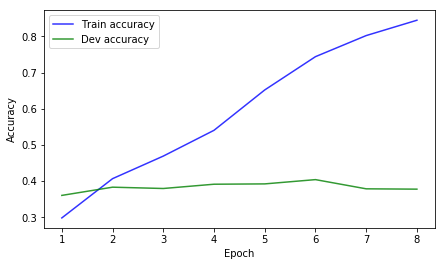

In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
x_train = np.array(train_int)
y_train = train_y
x_val = np.array(dev_int)
y_val = dev_y

bs = 64 # 267
n_epochs = 8

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))

plt.figure(figsize=(7,4))
plt.plot(history.history['acc'], c='blue', alpha=0.8, label='Train accuracy')
plt.plot(history.history['val_acc'], c='green', alpha=0.8, label='Dev accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i for i in range(n_epochs)], [i+1 for i in range(n_epochs)])
plt.legend(loc='best')
plt.show()

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
# Print confusion matrix on dev dataset, and score.
verbose = False
if verbose == True:
    dev_y_ = [row.argmax() for row in dev_y]
    pred_dev = model.predict_classes(dev_int)
    print(confusion_matrix(dev_y_, pred_test))
    print(accuracy_score(dev_y_, pred_test))

# Predict classes of test_int
pred_test = model.predict_classes(test_int)

# Saving results
file = open('data/logreg_lstm_y_test_sst.txt', 'w')
for l in pred_test:
    file.write(str(l))
    file.write("\n")
file.close()
print("Results saved !")

Results saved !


## 4.3 -- innovate !

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE